In [13]:
# Import MRI images 

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

BATCH = 64
num_epochs = 5
SAVE_PATH = "./DenseNet_MRI_tf.h5"
num_classes = 4
image_height = 176 
image_width = 208

# Set the directory paths
train_dir = '/projectnb/ec523kb/students/smkelley/Alzheimer_s Dataset/train'
test_dir = '/projectnb/ec523kb/students/smkelley/Alzheimer_s Dataset/test'

# Data transform     -> data already in RGB
data_transform = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255), # normalize images
#     layers.Lambda(lambda x: tf.image.resize(x, (176, 208))),  # Resizing to original size, might be optional
#     layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x))  # Converting grayscale to RGB
])


# Initialize ImageDataGenerator with data_transform
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=lambda x: data_transform(x, training=True))

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=lambda x: data_transform(x, training=False))


train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(image_height, image_width),
    color_mode='rgb',  # Set to 'grayscale' if your images are grayscale
    batch_size=BATCH,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(image_height, image_width),
    color_mode='rgb',
    batch_size=BATCH,
    class_mode='categorical')

# Create tensorflow datasets from the Data generators
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, image_height, image_width, 3], [None, num_classes])  # Shape adjusted for RGB
)

test_dataset = tf.data.Dataset.from_generator(
    lambda: test_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, image_height, image_width, 3], [None, num_classes])
)


Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [ ]:
# MODEL:
# initialize Densenet121 Architecture/ model
base_model = tf.keras.applications.DenseNet121(include_top=False, weights=None, input_shape=(176, 208, 3))
base_model.trainable = True

model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
# model.fit(train_dataset, epochs=num_epochs)
# Assuming you know the number of samples in your train and validation datasets
total_train_samples = 5121  # total number of training samples
total_val_samples = 1279  # total number of validation samples

model.fit(
    train_dataset, 
    epochs=num_epochs,
    steps_per_epoch=total_train_samples // BATCH
)


# Save model
model.save(SAVE_PATH)

print('Finished Training')

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Get predictions and true labels for the confusion matrix
test_labels, all_labels = [], []
for images, labels in test_dataset.unbatch().take(-1):
    preds = model.predict(np.expand_dims(images, axis=0))
    test_labels.append(np.argmax(labels))
    all_labels.append(np.argmax(preds))

# Create confusion matrix
conf_matrix = tf.math.confusion_matrix(test_labels, all_labels)

# Display confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Epoch 1/5
80/80 [==============================] - 1112s 14s/step - loss: 0.9043 - accuracy: 0.5719
Epoch 2/5
80/80 [==============================] - 1065s 13s/step - loss: 0.7469 - accuracy: 0.6626
Epoch 3/5
80/80 [==============================] - 1070s 13s/step - loss: 0.6047 - accuracy: 0.7400
Epoch 4/5
80/80 [==============================] - 1075s 13s/step - loss: 0.4726 - accuracy: 0.7995
Epoch 5/5
80/80 [==============================] - 1066s 13s/step - loss: 0.3234 - accuracy: 0.8691


/usr3/graduate/smkelley/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Finished Training
   1371/Unknown - 4306s 3s/step - loss: 3.1677 - accuracy: 0.5122

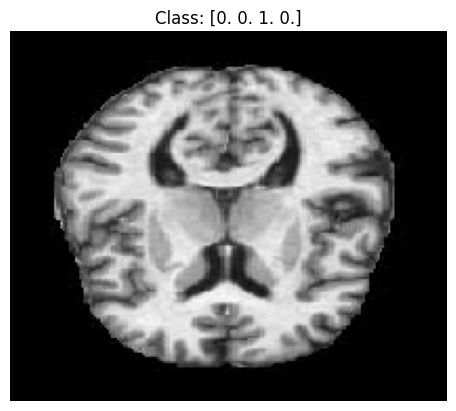

In [10]:
# import matplotlib.pyplot as plt

# # Load a batch of images from the training generator
# images, labels = next(train_generator)

# # Select the first image from this batch
# image = images[0]

# image = image[:, :, ::-1]  

# # Display the image
# plt.imshow(image)
# plt.title(f"Class: {labels[0]}")
# plt.axis('off')  # Turn off axis numbers
# plt.show()
